# Lesson 4: Azure OpenAI Function Calling Feature

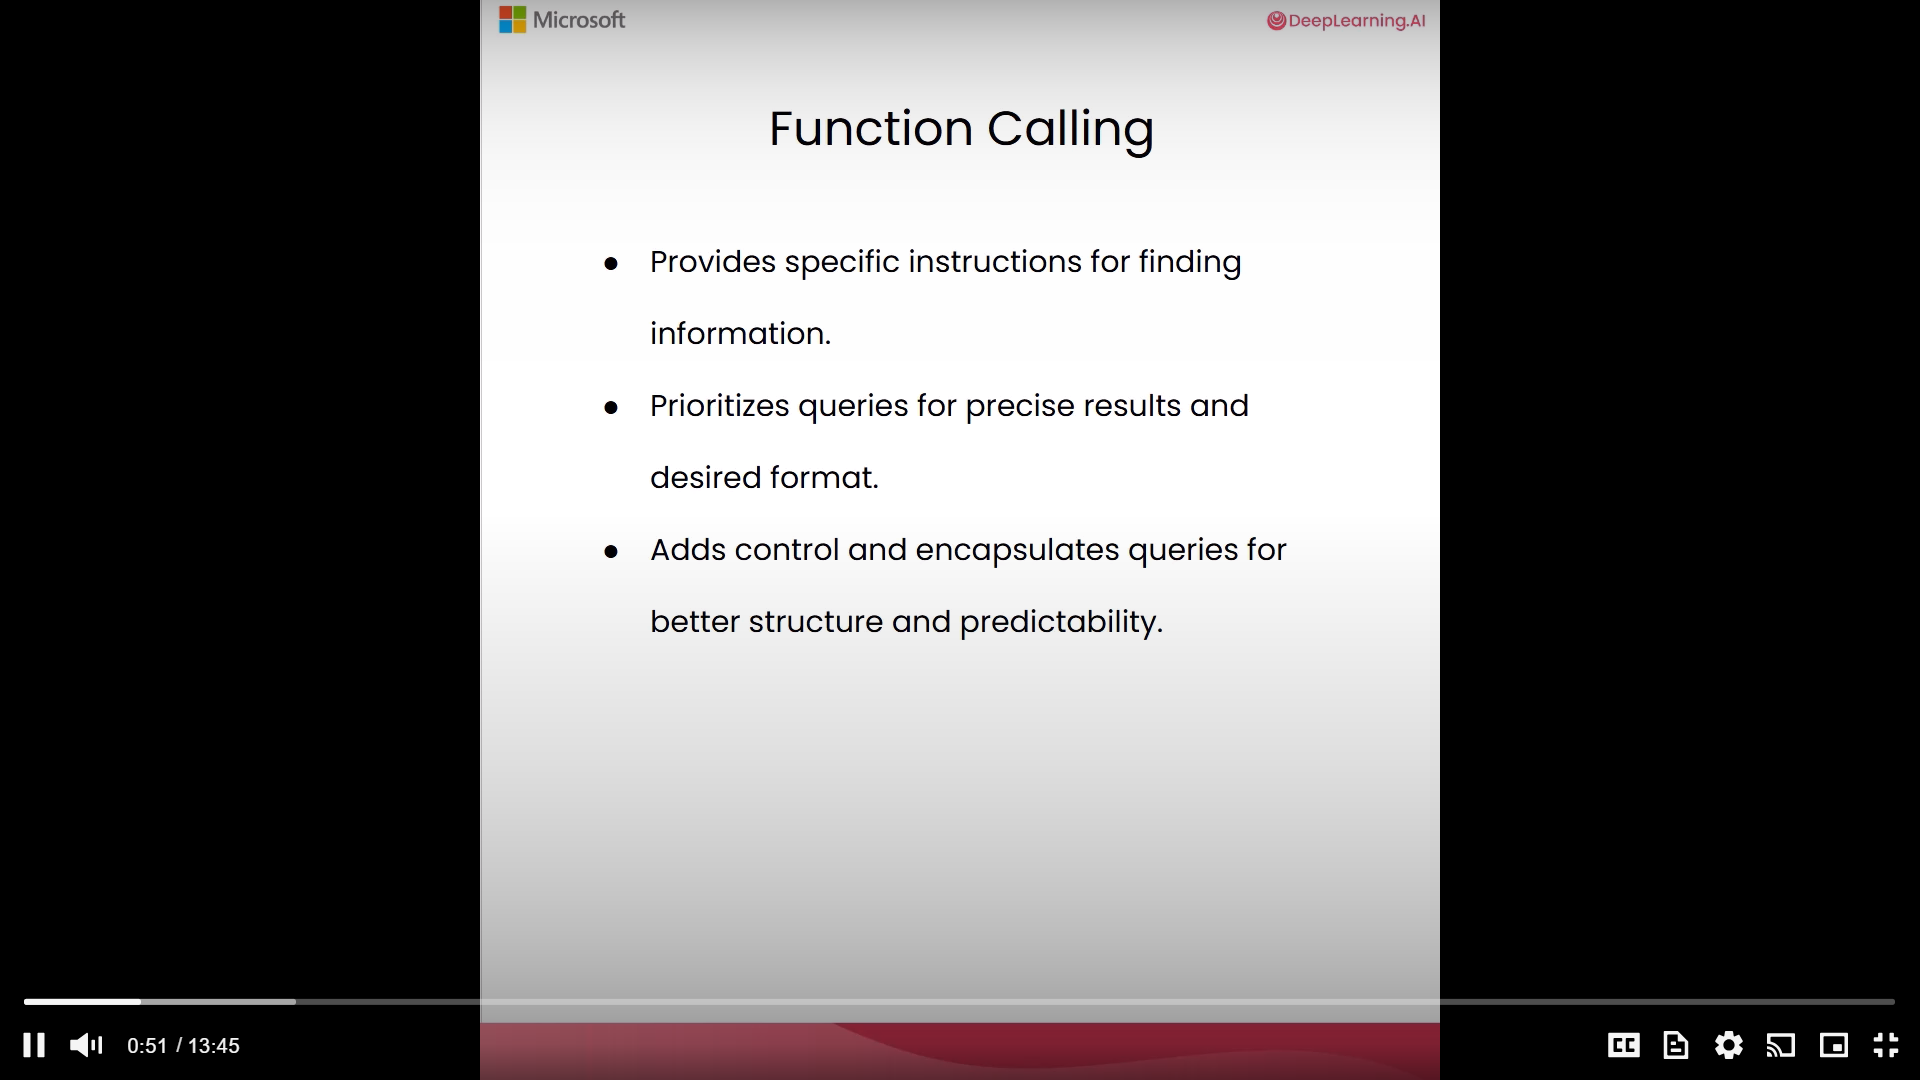

## Setup

**Note**: The pre-configured cloud resource grants you access to the Azure OpenAI GPT model. The key and endpoint provided below are intended for teaching purposes only. Your notebook environment is already set up with the necessary keys, which may differ from those used by the instructor during the filming.

In [1]:
import os
from openai import AzureOpenAI
import json

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),
  api_version="2023-05-15"
)

## 1. Using an illustrative example

In [2]:
def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather in a given location. 
    The default unit when not specified is fahrenheit"""
    if "new york" in location.lower():
        return json.dumps(
            {"location": "New York", "temperature": "40", "unit": unit}
        )
    elif "san francisco" in location.lower():
        return json.dumps(
            {"location": "San Francisco", "temperature": "50", "unit": unit}
        )
    elif "las vegas" in location.lower():
        return json.dumps(
            {"location": "Las Vegas", "temperature": "70", "unit": unit}
        )
    else:
        return json.dumps(
            {"location": location, "temperature": "unknown"}
        )

get_current_weather("New York")

'{"location": "New York", "temperature": "40", "unit": "fahrenheit"}'

### Define the tools

In [3]:
messages = [
    {"role": "user",
     "content": """What's the weather like in San Francisco,
                   New York, and Las Vegass?"""
    }
]

tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": """Get the current weather in a given
                              location.The default unit when not
                              specified is fahrenheit""",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": """The city and state,
                                        e.g. San Francisco, CA""",
                    },
                    "unit": {
                        "type": "string",
                        "default":"fahrenheit",
                        "enum": [ "fahrenheit", "celsius"],
                        "description": """The messuring unit for
                                          the temperature.
                                          If not explicitly specified
                                          the default unit is 
                                          fahrenheit"""
                    },
                },
                "required": ["location"],
            },
        },
    }
]

### Use the function calling

In [ ]:
response = client.chat.completions.create(
    model="gpt-4-1106",
    messages=messages,
    tools=tools,
    tool_choice="auto", 
)

response_message = response.choices[0].message
tool_calls = response_message.tool_calls

if tool_calls:
    print (tool_calls)
    
    available_functions = {
        "get_current_weather": get_current_weather,
    } 
    messages.append(response_message)  
    
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        function_to_call = available_functions[function_name]
        function_args = json.loads(tool_call.function.arguments)
        function_response = function_to_call(
            location=function_args.get("location"),
            unit=function_args.get("unit"),
        )
        messages.append(
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            }
        )  
    print (messages)

In [ ]:
second_response = client.chat.completions.create(
            model="gpt-4-1106",
            messages=messages,
        )
print (second_response)

## 2. Using our SQL database 

**Note**: To access the data locally, use the following code:

```
os.makedirs("data",exist_ok=True)
!wget https://covidtracking.com/data/download/all-states-history.csv -P ./data/
file_url = "./data/all-states-history.csv"
df = pd.read_csv(file_url).fillna(value = 0)
```

In [6]:
from sqlalchemy import create_engine
import pandas as pd

df = pd.read_csv("./data/all-states-history.csv").fillna(value = 0)

In [7]:
database_file_path = "./db/test.db"

engine = create_engine(f'sqlite:///{database_file_path}')

df.to_sql(
    'all_states_history',
    con=engine,
    if_exists='replace',
    index=False)

20780

### Create two functions

In [8]:
import numpy as np
from sqlalchemy import text

def get_hospitalized_increase_for_state_on_date(state_abbr, specific_date):
    try:
        query = f"""
        SELECT date, hospitalizedIncrease
        FROM all_states_history
        WHERE state = '{state_abbr}' AND date = '{specific_date}';
        """
        query = text(query)

        with engine.connect() as connection:
            result = pd.read_sql_query(query, connection)
        if not result.empty:
            return result.to_dict('records')[0]
        else:
            return np.nan
    except Exception as e:
        print(e)
        return np.nan

In [9]:
def get_positive_cases_for_state_on_date(state_abbr, specific_date):
    try:
        query = f"""
        SELECT date, state, positiveIncrease AS positive_cases
        FROM all_states_history
        WHERE state = '{state_abbr}' AND date = '{specific_date}';
        """
        query = text(query)

        with engine.connect() as connection:
            result = pd.read_sql_query(query, connection)
        if not result.empty:
            return result.to_dict('records')[0]
        else:
            return np.nan
    except Exception as e:
        print(e)
        return np.nan

In [10]:
get_hospitalized_increase_for_state_on_date("AK","2021-03-05")

{'date': '2021-03-05', 'hospitalizedIncrease': 3}

### Execute the function calling against the SQL database

In [11]:
messages = [
    {"role": "user",
     "content": """ how many hospitalized people we had in Alaska
                    the 2021-03-05?"""
    }
]

In [12]:
tools_sql = [
    {
        "type": "function",
        "function": {
            "name": "get_hospitalized_increase_for_state_on_date",
            "description": """Retrieves the daily increase in
                              hospitalizations for a specific state
                              on a specific date.""",
            "parameters": {
                "type": "object",
                "properties": {
                    "state_abbr": {
                        "type": "string",
                        "description": """The abbreviation of the state
                                          (e.g., 'NY', 'CA')."""
                    },
                    "specific_date": {
                        "type": "string",
                        "description": """The specific date for
                                          the query in 'YYYY-MM-DD'
                                          format."""
                    }
                },
                "required": ["state_abbr", "specific_date"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_positive_cases_for_state_on_date",
            "description": """Retrieves the daily increase in 
                              positive cases for a specific state
                              on a specific date.""",
            "parameters": {
                "type": "object",
                "properties": {
                    "state_abbr": {
                        "type": "string",
                        "description": """The abbreviation of the 
                                          state (e.g., 'NY', 'CA')."""
                    },
                    "specific_date": {
                        "type": "string",
                        "description": """The specific date for the
                                          query in 'YYYY-MM-DD'
                                          format."""
                    }
                },
                "required": ["state_abbr", "specific_date"]
            }
        }
    }
]

In [ ]:
response = client.chat.completions.create(
    model="gpt-4-1106",
    messages=messages,
    tools=tools_sql,
    tool_choice="auto",
)

response_message = response.choices[0].message
tool_calls = response_message.tool_calls

if tool_calls:
    print (tool_calls)
    
    available_functions = {
        "get_positive_cases_for_state_on_date": get_positive_cases_for_state_on_date,
        "get_hospitalized_increase_for_state_on_date":get_hospitalized_increase_for_state_on_date
    }  
    messages.append(response_message)  
   
    for tool_call in tool_calls:
        function_name = tool_call.function.name
        function_to_call = available_functions[function_name]
        function_args = json.loads(tool_call.function.arguments)
        function_response = function_to_call(
            state_abbr=function_args.get("state_abbr"),
            specific_date=function_args.get("specific_date"),
        )
        messages.append(
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": str(function_response),
            }
        ) 
    print(messages)

In [ ]:
second_response = client.chat.completions.create(
            model="gpt-4-1106",
            messages=messages,
        )
print (second_response)